In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
# 1. Define and store the data provided in the query in a dictionary.
with open("/home/ubuntu/models_implem/optim_vision/benchmark_outputs/json/processor_benchmark.json", "r") as file:
    data = json.load(file)

# 2. Create a DataFrame out of the dictionary
rows = []
for model, hardware_data in data.items():
    for hardware, library_data in hardware_data.items():
        for library, datatype_data in library_data.items():
            if "Optim" in library:
                datatype = library.split(" ")[1][1:-1]  # Extract datatype from library name
            else:
                datatype = ""
            rows.append({
                "Model": model,
                "Device": hardware,
                "Type": library,
                "Datatype": datatype,
                "Total": datatype_data["total"],
                "Loading Time (s)": datatype_data["loading"],
                "Processing Time (s)": datatype_data["processing"]
            })
df_extended = pd.DataFrame(rows)
# Data conversion to milliseconds
df_extended["Loading Time (ms)"] = df_extended["Loading Time (s)"] * 1000
df_extended["Processing Time (ms)"] = df_extended["Processing Time (s)"] * 1000
df_extended["Total"] = df_extended["Total"] * 1000


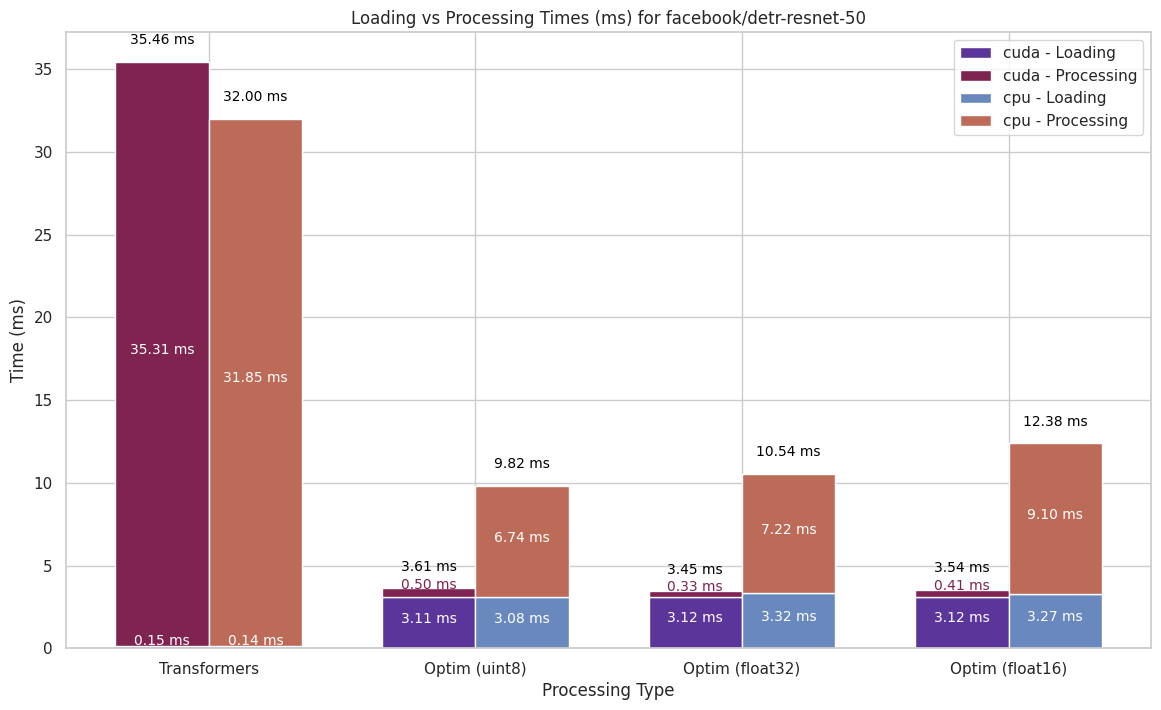

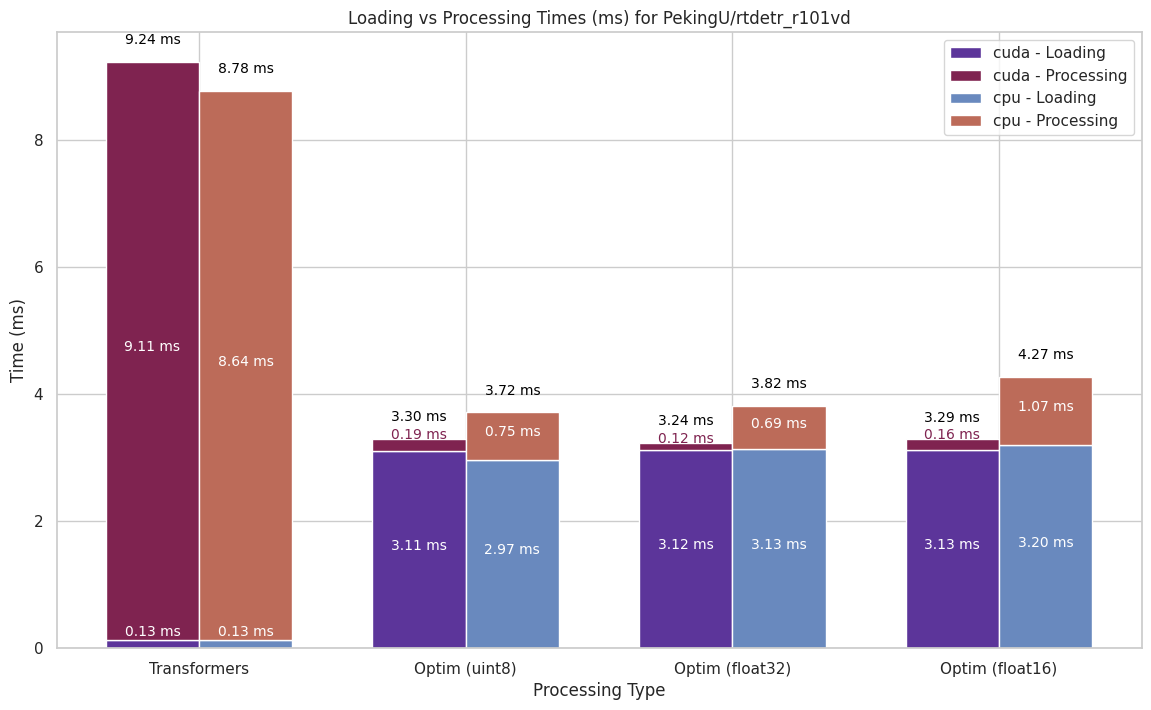

In [2]:
# Plotting using Matplotlib

# Defining the bar positions
types = df_extended["Type"].unique()
device_groups = df_extended["Device"].unique()
model_groups = df_extended["Model"].unique()
bar_width = 0.35  # Width of the bars
index = np.arange(len(types))  # Grouped bar positions

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")
# set color palette with seaborn
color = sns.color_palette(palette='twilight_shifted')
# Plotting the bars for each device and time type
for model in model_groups:
    # get max total time for each model
    max_total = df_extended[df_extended["Model"] == model]["Total"].max()
    fig, ax = plt.subplots(figsize=(14, 8))
    for i, device in enumerate(device_groups):
        df_device = df_extended[df_extended["Device"] == device]
        df_device = df_device[df_device["Model"] == model]
        ax.bar(index + i * bar_width, df_device["Loading Time (ms)"], bar_width, label=f'{device} - Loading', color=color[i])
        ax.bar(index + i * bar_width, df_device["Processing Time (ms)"], bar_width,
            bottom=df_device["Loading Time (ms)"], label=f'{device} - Processing', color=color[-1-i])

    # Adding text annotations
    for i, device in enumerate(device_groups):
        df_device = df_extended[df_extended["Device"] == device]
        df_device = df_device[df_device["Model"] == model]
        for j in range(len(df_device)):
            # Loading time annotation
            ax.text(index[j] + i * bar_width, max(df_device["Loading Time (ms)"].iloc[j]/2, 0.2),
                    f'{df_device["Loading Time (ms)"].iloc[j]:.2f} ms', ha='center', fontsize=10, color="white")
            # Processing time annotation
            base_height = df_device["Loading Time (ms)"].iloc[j]
            added_height = df_device["Processing Time (ms)"].iloc[j]
            if added_height < 0.6:
                ax.text(index[j] + i * bar_width, base_height+added_height,
                    f'{df_device["Processing Time (ms)"].iloc[j]:.2f} ms', ha='center', fontsize=10, color=color[-1-i])
            else:
                ax.text(index[j] + i * bar_width, base_height+added_height/2,
                    f'{df_device["Processing Time (ms)"].iloc[j]:.2f} ms', ha='center', fontsize=10, color="white")
            ax.text(index[j] + i * bar_width, base_height+added_height+max_total*0.03,
                    f'{df_device["Total"].iloc[j]:.2f} ms', ha='center', fontsize=10, color="black")

    # Adding labels, title, and legend
    ax.set_xlabel('Processing Type')
    ax.set_ylabel('Time (ms)')
    ax.set_title(f'Loading vs Processing Times (ms) for {model}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(types)
    ax.legend()

    # Display the plot
    plt.show()

In [3]:
with open("/home/ubuntu/models_implem/optim_vision/load_from_path_to_tensor_gpu.json", "r") as file:
    data = json.load(file)["load_from_path_to_tensor_gpu"]

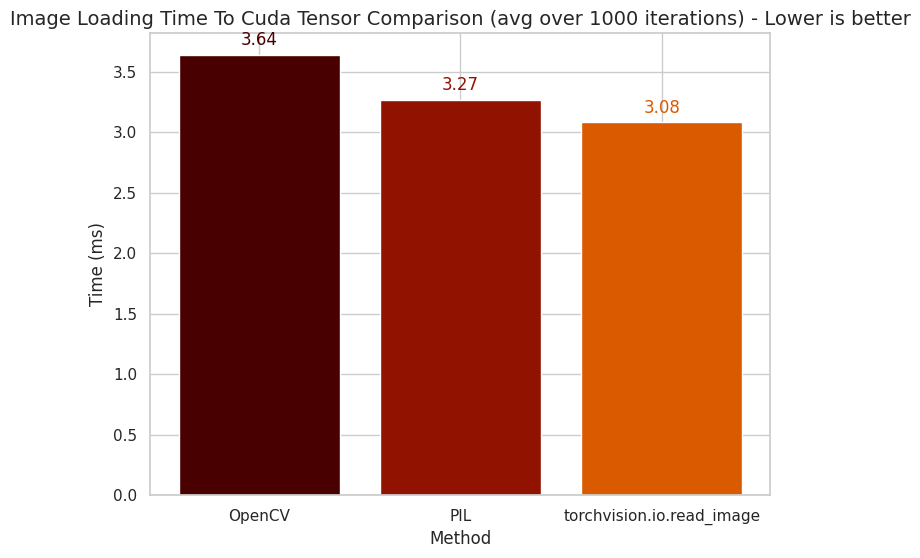

In [4]:
# Creating the bar plot
labels = list(data.keys())
values = list(data.values())
# sort by slowest to fastest
labels, values = zip(*sorted(zip(labels, values), key=lambda x: x[1], reverse=True))

# convert to milliseconds
values = [value * 1000 for value in values]

color = sns.color_palette(palette='afmhot')

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=color)

# Adding title and labels
plt.title('Image Loading Time To Cuda Tensor Comparison (avg over 1000 iterations) - Lower is better', fontsize=14)
plt.xlabel('Method', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
# plot time values on top of bars
for i, value in enumerate(values):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=12, color=color[i])

# Show plot
plt.show()

In [5]:
with open("/home/ubuntu/models_implem/optim_vision/benchmark_outputs/json/change_dtype_from_uint8_2.json", "r") as file:
    data = json.load(file)

<Figure size 3600x2400 with 0 Axes>

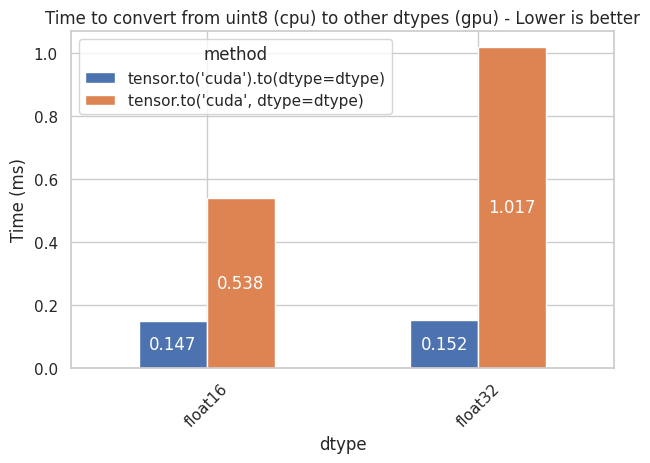

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert data to DataFrame
df = pd.DataFrame([(dtype, method, time)
                   for dtype, methods in data.items()
                   for method, time in methods.items()],
                  columns=['dtype', 'method', 'time'])

# change time to ms
df['time'] = df['time'] * 1000

# Plot
plt.figure(figsize=(12, 8), dpi=300)
ax = df.pivot(index='dtype', columns='method', values='time').plot(kind='bar')
plt.title('Time to convert from uint8 (cpu) to other dtypes (gpu) - Lower is better')
plt.xlabel('dtype')
plt.ylabel('Time (ms)')
plt.xticks(rotation=45)
# change ax dpi


# Add labels with time values on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()/2),
                ha='center', va='center', xytext=(0, 0), textcoords='offset points', color='white')
# Option 1: Move legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Option 2: Move legend inside the plot
# plt.legend(loc='upper right', bbox_to_anchor=(0.8, 0.9))

# Option 3:  Adjust plot layout to make space for the legend
plt.tight_layout()

plt.show()

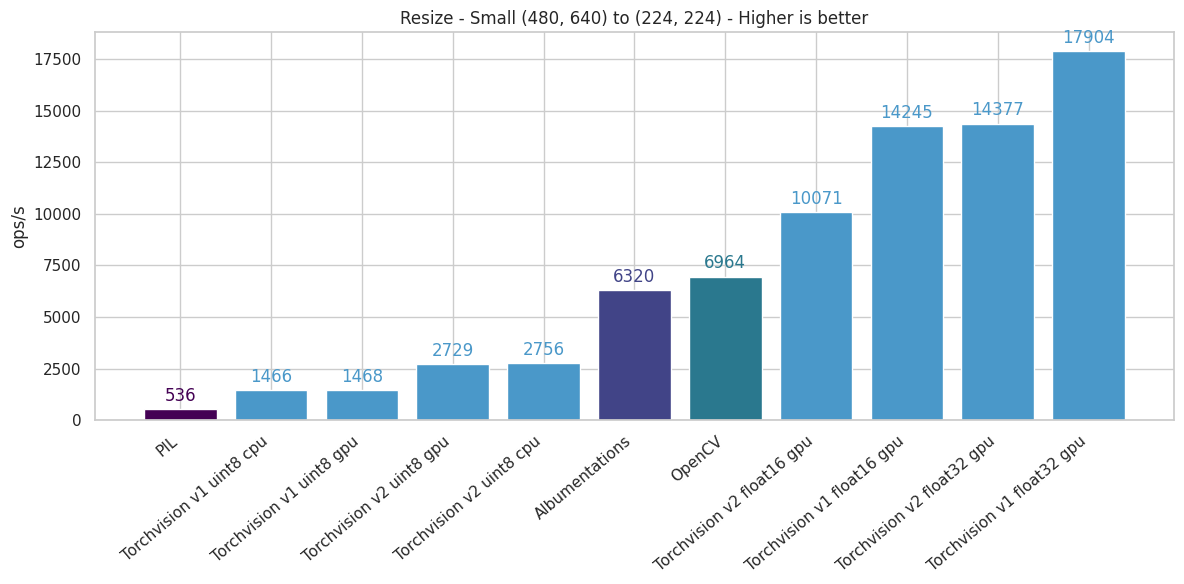

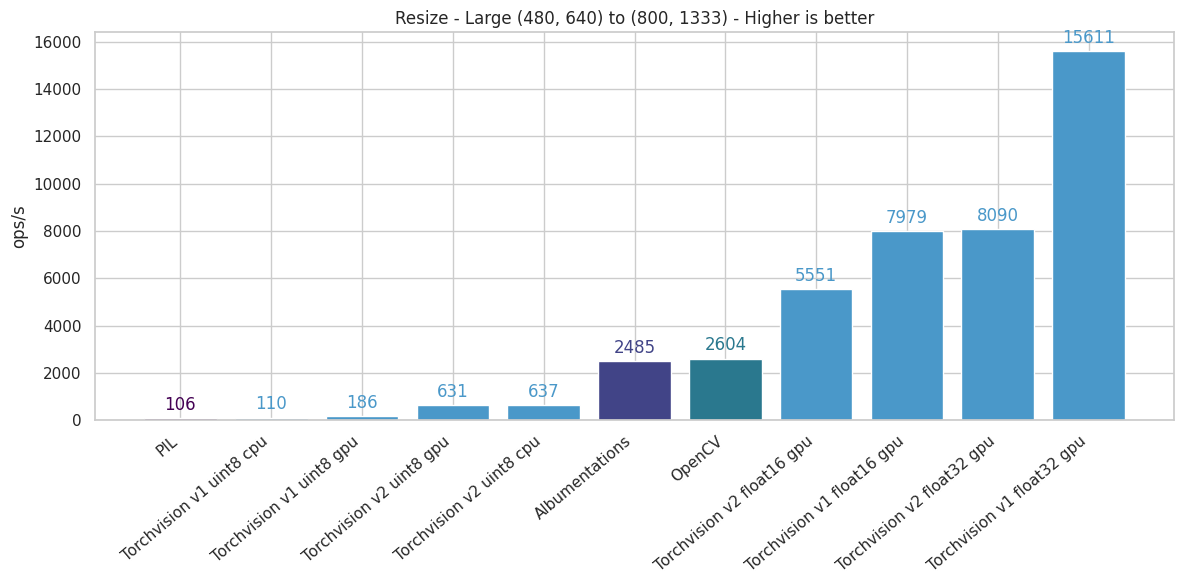

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Data
with open("/home/ubuntu/models_implem/optim_vision/benchmark_outputs/json/image_processing_ops.json", "r") as file:
    data = json.load(file)
# Calculate ops/s and assign colors
resize_data = {}
color_map_resize = {}
for size in data['resize']:
    resize_data[size] = {'Torchvision': {}, 'Others': {}}
    color_map_resize[size] = {'Torchvision': [], 'Others': []}
    color_idx = 0

    # Calculate ops/s and store in a list of tuples
    ops_s_list = [(key, 1/val) for key, val in data['resize'][size]['times'].items()]
    # Sort the list of tuples by ops/s in ascending order
    ops_s_list.sort(key=lambda item: item[1])

    for x_pos, (key, ops) in enumerate(ops_s_list):  # Use sorted list
        if 'Torchvision' in key:
            resize_data[size]['Torchvision'][x_pos] = ops
            color_map_resize[size]['Torchvision'].append(cm.Blues(0.6))
        else:
            resize_data[size]['Others'][x_pos] = ops
            color_map_resize[size]['Others'].append(cm.viridis(color_idx / 10))
            color_idx += 2

# Plotting the 'resize' data
plt.figure(figsize=(12, 6))

# Get the bar plot objects
bars_torchvision = plt.bar(resize_data['small']['Torchvision'].keys(), resize_data['small']['Torchvision'].values(), color=color_map_resize['small']['Torchvision'])
bars_others = plt.bar(resize_data['small']['Others'].keys(), resize_data['small']['Others'].values(), color=color_map_resize['small']['Others'])
plt.title('Resize - Small (480, 640) to (224, 224) - Higher is better')
plt.ylabel('ops/s')

# Set xticks explicitly with adjusted horizontal alignment
ax = plt.gca()
x = np.arange(len(ops_s_list))
xlabels = [item[0] for item in ops_s_list]
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=40, ha='right')

# Add ops/s values above bars with matching colors
for bar in (bars_torchvision+bars_others):
    height = bar.get_height()
    ax.annotate(f'{height:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                color=bar.get_facecolor())

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
bars_torchvision = plt.bar(resize_data['large']['Torchvision'].keys(), resize_data['large']['Torchvision'].values(), color=color_map_resize['large']['Torchvision'])
bars_others = plt.bar(resize_data['large']['Others'].keys(), resize_data['large']['Others'].values(), color=color_map_resize['large']['Others'])
plt.title('Resize - Large (480, 640) to (800, 1333) - Higher is better')
plt.ylabel('ops/s')

# Set xticks explicitly with adjusted horizontal alignment
ax = plt.gca()
x = np.arange(len(ops_s_list))
xlabels = [item[0] for item in ops_s_list]
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=40, ha='right')

# Add ops/s values above bars with matching colors
for bar in (bars_torchvision+bars_others):
    height = bar.get_height()
    ax.annotate(f'{height:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                color=bar.get_facecolor())


plt.tight_layout()
plt.show()

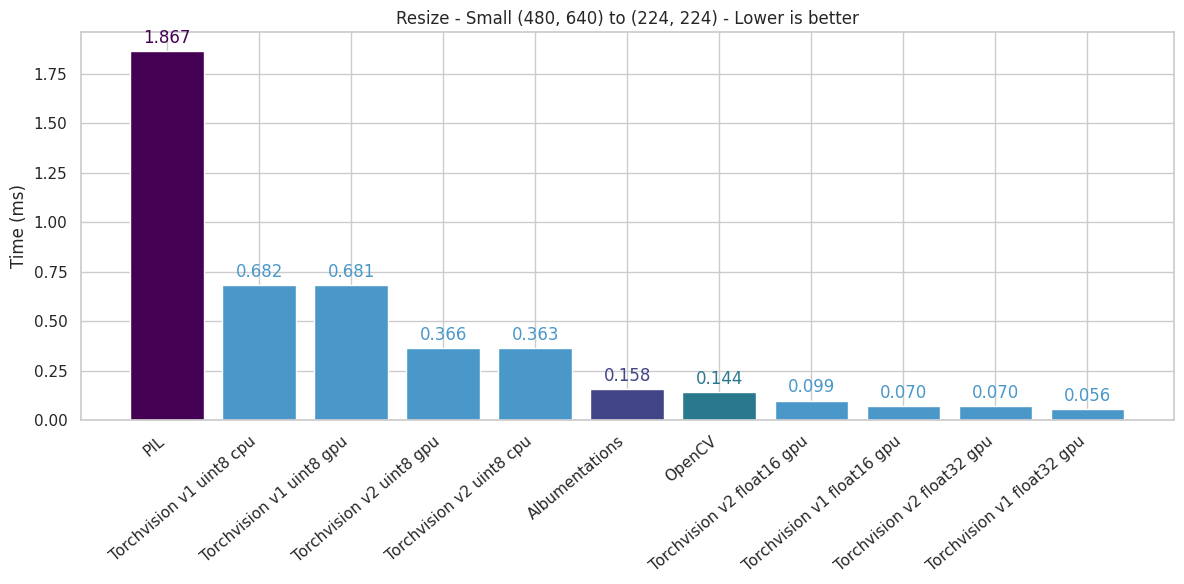

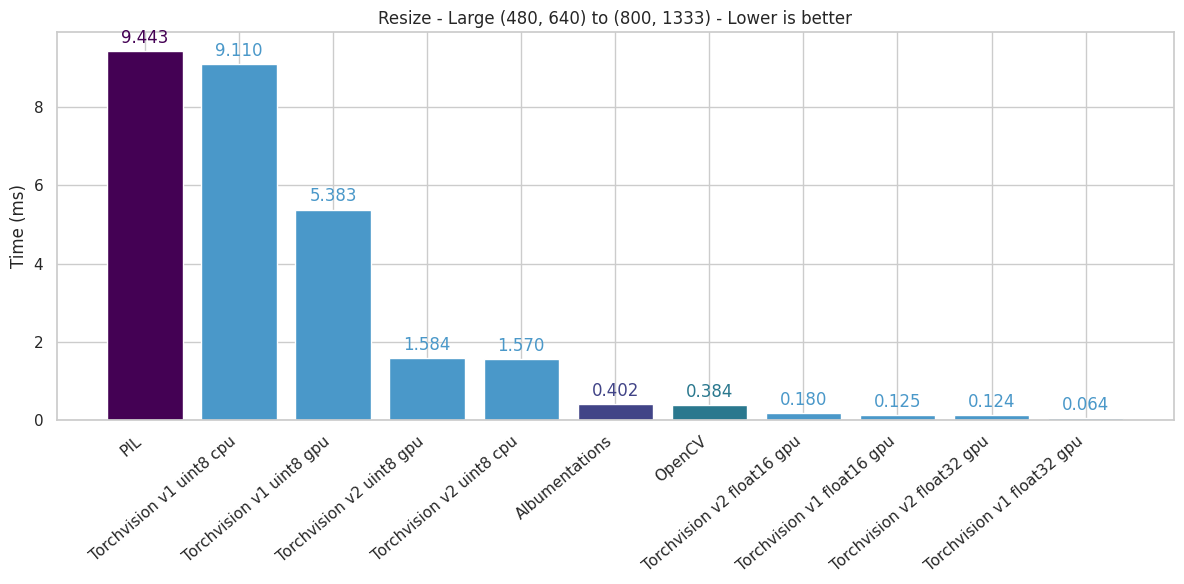

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Data
with open("/home/ubuntu/models_implem/optim_vision/benchmark_outputs/json/image_processing_ops.json", "r") as file:
    data = json.load(file)
# Calculate ops/s and assign colors
resize_data = {}
color_map_resize = {}
for size in data['resize']:
    resize_data[size] = {'Torchvision': {}, 'Others': {}}
    color_map_resize[size] = {'Torchvision': [], 'Others': []}
    color_idx = 0

    # Calculate ops/s and store in a list of tuples
    ops_s_list = [(key, val*1000) for key, val in data['resize'][size]['times'].items()]
    # Sort the list of tuples by ops/s in ascending order
    ops_s_list.sort(key=lambda item: item[1], reverse=True)

    for x_pos, (key, ops) in enumerate(ops_s_list):  # Use sorted list
        if 'Torchvision' in key:
            resize_data[size]['Torchvision'][x_pos] = ops
            color_map_resize[size]['Torchvision'].append(cm.Blues(0.6))
        else:
            resize_data[size]['Others'][x_pos] = ops
            color_map_resize[size]['Others'].append(cm.viridis(color_idx / 10))
            color_idx += 2

# Plotting the 'resize' data
plt.figure(figsize=(12, 6))

# Get the bar plot objects
bars_torchvision = plt.bar(resize_data['small']['Torchvision'].keys(), resize_data['small']['Torchvision'].values(), color=color_map_resize['small']['Torchvision'])
bars_others = plt.bar(resize_data['small']['Others'].keys(), resize_data['small']['Others'].values(), color=color_map_resize['small']['Others'])
plt.title('Resize - Small (480, 640) to (224, 224) - Lower is better')
plt.ylabel('Time (ms)')

# Set xticks explicitly with adjusted horizontal alignment
ax = plt.gca()
x = np.arange(len(ops_s_list))
xlabels = [item[0] for item in ops_s_list]
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=40, ha='right')

# Add ops/s values above bars with matching colors
for bar in (bars_torchvision+bars_others):
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                color=bar.get_facecolor())

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
bars_torchvision = plt.bar(resize_data['large']['Torchvision'].keys(), resize_data['large']['Torchvision'].values(), color=color_map_resize['large']['Torchvision'])
bars_others = plt.bar(resize_data['large']['Others'].keys(), resize_data['large']['Others'].values(), color=color_map_resize['large']['Others'])
plt.title('Resize - Large (480, 640) to (800, 1333) - Lower is better')
plt.ylabel('Time (ms)')

# Set xticks explicitly with adjusted horizontal alignment
ax = plt.gca()
x = np.arange(len(ops_s_list))
xlabels = [item[0] for item in ops_s_list]
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=40, ha='right')

# Add ops/s values above bars with matching colors
for bar in (bars_torchvision+bars_others):
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                color=bar.get_facecolor())


plt.tight_layout()
plt.show()

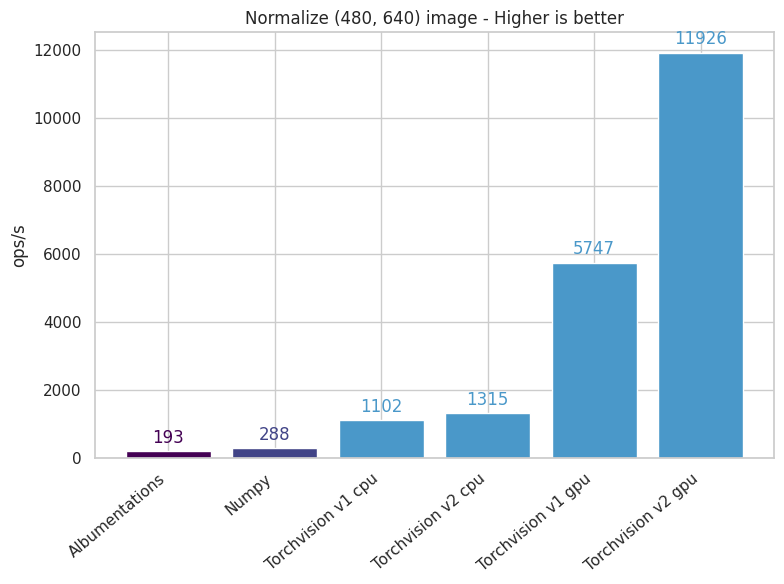

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- Normalize Data ---
normalize_data = {'Torchvision': {}, 'Others': {}}
color_map_normalize = {'Torchvision': [], 'Others': []}
color_idx = 0

# Calculate ops/s and store in a list of tuples
ops_s_list_normalize = [(key, 1/val) for key, val in data['normalize']['times'].items()]
# Sort the list of tuples by ops/s in ascending order
ops_s_list_normalize.sort(key=lambda item: item[1])

for x_pos, (key, ops) in enumerate(ops_s_list_normalize):
    if 'Torchvision' in key:
        normalize_data['Torchvision'][x_pos] = ops
        color_map_normalize['Torchvision'].append(cm.Blues(0.6))
    else:
        normalize_data['Others'][x_pos] = ops
        color_map_normalize['Others'].append(cm.viridis(color_idx / 10))
        color_idx += 2



# --- Plotting the 'normalize' data ---
plt.figure(figsize=(8, 6))

# Get the bar plot objects
bars_torchvision = plt.bar(normalize_data['Torchvision'].keys(), normalize_data['Torchvision'].values(), color=color_map_normalize['Torchvision'])
bars_others = plt.bar(normalize_data['Others'].keys(), normalize_data['Others'].values(), color=color_map_normalize['Others'])

plt.title('Normalize (480, 640) image - Higher is better')
plt.ylabel('ops/s')

# Set xticks explicitly with adjusted horizontal alignment
ax = plt.gca()
x = np.arange(len(ops_s_list_normalize))
xlabels = [item[0] for item in ops_s_list_normalize]
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=40, ha='right')

# Add ops/s values above bars with matching colors
for bar in (bars_torchvision+bars_others):
    height = bar.get_height()
    ax.annotate(f'{height:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                color=bar.get_facecolor())



plt.tight_layout()
plt.show()

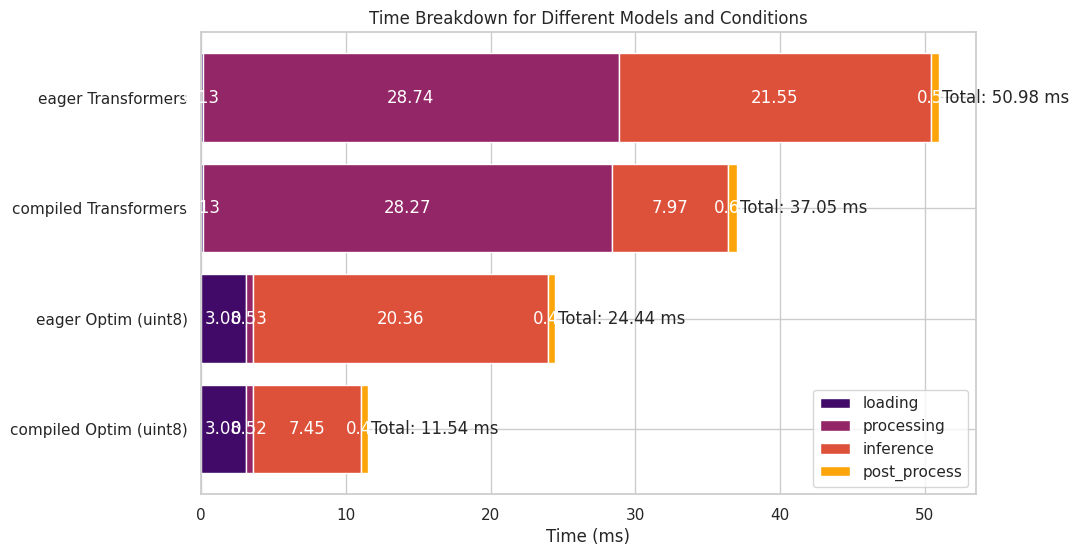

In [35]:
import matplotlib.pyplot as plt

path = "/home/ubuntu/models_implem/optim_vision/benchmark_outputs/json/benchmark_results_full_pipeline_detr.json"
# path = "/home/ubuntu/models_implem/optim_vision/benchmark_outputs/json/benchmark_results_full_pipeline_dtypes_proc_comp.json"
# Data for the plot
with open(path, "r") as file:
    data = json.load(file)

labels = list(data["eager"]["Transformers"].keys())[1:]  # Exclude "total" from labels
colors = sns.color_palette("inferno", 4)

# Flatten the data into a list of tuples for sorting
flattened_data = [
    (condition, model, model_data)
    for condition, models in data.items()
    for model, model_data in models.items()
]

# Sort the flattened data by total time in descending order
sorted_data = sorted(flattened_data, key=lambda item: item[2]["total"], reverse=False)

# filter out model with "float" in them:
sorted_data = [item for item in sorted_data if "float" not in item[1]]

# Restructure the sorted data back into the nested dictionary format
restructured_data = {}
for condition, model, model_data in sorted_data:
    if condition not in restructured_data:
        restructured_data[condition] = {}
    restructured_data[condition][model] = model_data

# Create the bar plot
plt.figure(figsize=(10, 6))

bar_index = 0
for condition, model, times in sorted_data:
    values = list(times.values())[1:]

    # plt.barh(bar_index, values[0] * 1000, color='lightgray', label=f'{model} {condition} Total')

    left = 0
    for j in range(len(values)):
        plt.barh(
            bar_index,
            values[j] * 1000,
            left=left,
            color=colors[j],
            label=f"{labels[j]}" if bar_index == 0 else "",
        )

        plt.text(
            left + values[j] * 1000 / 2,
            bar_index,
            f"{values[j] * 1000:.2f}",
            ha="center",
            va="center",
            color="white",
        )

        left += values[j] * 1000

    plt.text(
        left + 0.2,
        bar_index,
        f'Total: {times["total"] * 1000:.2f} ms',
        va="center",
    )

    bar_index += 1

# Add labels, title, and legend
plt.xlabel("Time (ms)")
plt.title("Time Breakdown for Different Models and Conditions")
plt.yticks(
    range(len(restructured_data) * len(restructured_data["eager"])),
    [f"{model} {condition}" for model, condition, _ in sorted_data],
)
plt.legend()

plt.show()